In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [52]:
# helpers

def scatter(pts):
  # pts - DxN array
  plt.scatter(*pts)
  plt.grid(True)
  plt.gca().set_aspect('equal')
  plt.xlim(-4,4)
  plt.ylim(-4,4)
  # plt.show()


def plot_proj(X, *vs):
    s = np.linspace(-100., 100.)
    scatter(X)
    for v in vs:
        proj = v @ X
        plt.plot(*(v[:,None] @ s[None,:]),c='black')
        scatter(proj * v[:,None])
    # print(f"var of projection onto v={v} is {(v @ X).var()}")
    plt.grid(True)
    plt.show()


# Prinicipal Component Analysis

In this post I want to derive and explore a basic _data analysis/machine learning_ technique called PCA - Prinicipal Component Analysis. It is a fun technique that connects optimization with linear algebra, and has a couple of interesting interperations and uses. Let's dive into it.

## TODO:
- why isn't the projection perfect?
- isometric graphs
- motivation
- the noise setting: 
  - what is the model? $x+n$?
  - how does gaussian noise affect the pca?
  - is it considered denoising to get rid of 

## Some Theoretical Exploration

### Problem Statement and Derivations

We start with some dataset $\mathcal X=\{x_i\}_{i=1}^n$ containing $n$ data samples, each with $k$ features [need distribution?]. We can then arrange them in a matrix $\mathbf X$, stacking each sample horizontaly as column vectors.

$$\mathbf X=\begin{bmatrix}
\vec{x_1} & \vec{x_2} &\cdots & \vec{x_n}
\end{bmatrix}$$

An example when $k=2$ would be:



'X dims are (2, 100)'

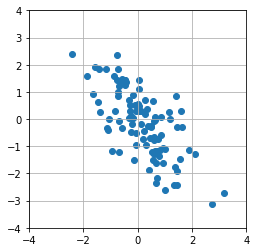

In [22]:
N = 100
X = np.random.multivariate_normal([0,0], [[1,-1],[-1,2]], N).T
scatter(X)
f'X dims are {X.shape}' # TODO: opposite what I expected

Given some unit vector $v\in\mathbb R^k$ we could project all our samples onto the line spanned by $v$ 

projecting onto [1,0] after normalization


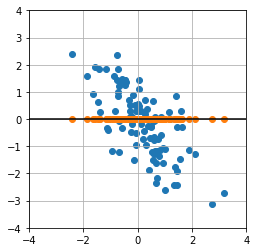

projecting onto [1,1] after normalization


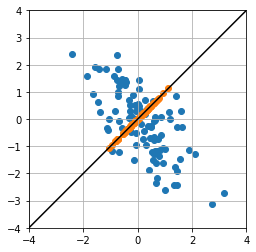

In [56]:
v = np.array([1,0])
v = v / np.linalg.norm(v)
print("projecting onto [1,0] after normalization")
plot_proj(X, v)

print("projecting onto [1,1] after normalization")
v = np.array([1,1])
v = v / np.linalg.norm(v)
plot_proj(X, v)

We can see that in the first direction the points seem to be more spread out than in the second direction. Intuitivly, the data seem to vary more in the first direction, which we might deduce to mean that this direction is more informative or important.

To measure the variabilty, we can calculate the empirical variance of the projected points
$$\sum_{i=1}^n (p(x_i)-\widehat{p(x)})^2$$
where $\widehat{p(x)}$ is the empirical mean of the projections. Let's try to find this maximizing vector:


### Finding the vector of largest variance

In [5]:
# TODO: better parametrization
def ascend(X, seed=None):
    np.random.seed(seed)
    flip = X[0].var() > X[1].var() # hack for numeric instability
    if flip:
        X = np.flip(X, axis=0)
        
    a = np.random.uniform(-1,1);
    for i in range(1000):
        v = np.array([a, np.sqrt(1-a**2)])
        proj = v @ X
        lr = 7e-4
        da = (proj * ([1, -a/np.sqrt(1-a**2)] @ X)).sum() # gradient with respect to a
        assert -1 < a + lr * da < 1, "a out of bounds"
        
        #update step
        a = a + lr * da
    v = np.array([a, np.sqrt(1-a**2)])
    if flip:
        v = np.array([np.sqrt(1-a**2), a])
    return v

var of projection onto v=[-0.59355331  0.80479467] is 2.0492135251700625


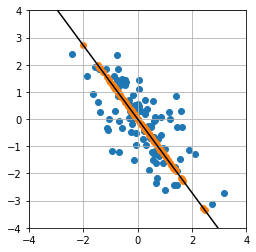

In [46]:
ev1 = ascend(X)
plot_proj(X, ev1)

`. Some directions will vary more than others, and we can try to choose some orthogonal [Why orthogonal?] set of such vectors, ordered by variance. Let's give it a try. First we sample some points
We can see along one direction the variance is larger. Motivated by the introduction, we try and search for the direction of largest variance. Since this problem is convex [Show!] we can use gradient ascent. Of course, the tricky part is we are actually in a constrained optimization but with a naive parametrization and some tricks we can get it to work`

Walla! we (apparently) managed to find what we wanted. How can we go about finding the second direction? If we will eventually get a collection of orthogonal vectors, then each datapoint will be a linear combination of these vectors. Maybe if we subtract our first vector from the dataset and repeat the process, we will get the next vector? [meh, i don't like this reasoning]

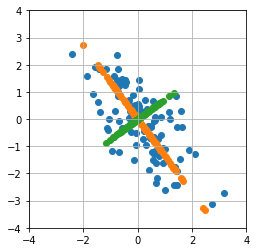

In [47]:
scatter(X)
scatter((ev1 @ X * ev1[:, None]))
scatter((X - ev1 @ X * ev1[:, None]))

var of projection onto v=[0.86518018 0.50146113] is 0.39804864250341837


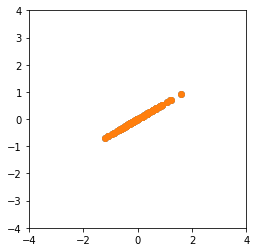

In [8]:
X1 = X - ev1 @ X * ev1[:, None]
ev2 = ascend(X1)
plot_proj(X1, ev2)

var of projection onto v=[0.86518018 0.50146113] is 0.36763843928132656


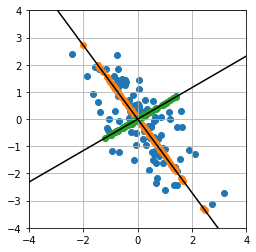

In [48]:
ev2 = ev2 / np.linalg.norm(ev2)
plot_proj(X, ev1, ev2)

In [10]:
O = np.c_[ev1,ev2]
O @  (X @ X.T / N) @ O.T

array([[ 3.09583316e+00, -4.26998390e-15],
       [-4.19366579e-15,  3.99158130e-01]])

### A closed form solution

Theoretically, we could repeat this procedure $k$ times as the number of the features, but it's iterative nature is somewhat problematic. Instead, lets examine what we are calculating more carefully. In the optimization we are trying to minimize the empirical variance of the projection
$$\min_{v,\|v\|=1} Var(v^TX)$$
it can also be written as
$$\min_{v,\|v\|=1} \frac{v^TXX^Tv}{n}=v^T\left(\frac{XX^T}{n}\right)v$$
The matrix $XX^T$ is symmetric and so can be diagonalized, ie, there exists an orthogonal matrix $O$ and diagonal matrix $D$ (holding $XX^T$'s eigenvalues in descending order such that 
$$XX^T=O D O^T$$
Rewriting (and ignoring the constant $n$) we get
$$\min_{v,\|v\|=1} v^TODO^Tv$$
Since $O$ is orthogonal it keeps the unit circle intact, so if we denote $u=O^Tv$ we can optimize directly on $u$
$$\min_{u,\|u\|=1} u^TDu$$
You can convince yourself that the minimizing vector will be $e_1$, the first standard basis vector, and thus we get
$$v=Oe_1$$
which will be the first eigenvector of $XX^T$. This similarly extends to the rest of the principal directions. Thus we really only need to find the eigenvectors of $XX^T$.

var of projection onto v=[ 0.50146113 -0.86518018] is 3.0440599817797986


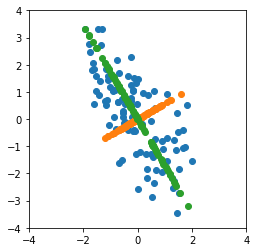

In [11]:
values, vectors = np.linalg.eig(X@X.T/N)
plot_proj(X, *vectors.T)

In practice we actually compute another decomposition called the *Singular Value Decomposition* which operates on $X$ directly (thus saving the matrix multiplication). It is related to the eigenvalue decomposition and gives us the principal components.

In [12]:
U, D, Vh = np.linalg.svd(X)

var of projection onto v=[0.86518018 0.50146113] is 0.3980486425034186


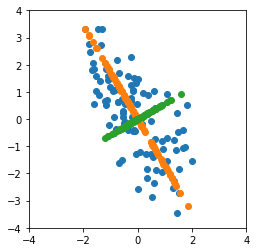

In [13]:
plot_proj(X, *U.T)

## Uses
- Dimensionality reduction
- Denoising
- Compression
- Data exploration


### PCA in images

running out of ram - used `full_matrices=False`  
[Eigenfaces](https://en.wikipedia.org/wiki/Eigenface)

In [14]:
import torchvision.datasets as dset
mnist = dset.MNIST('./mnist/', download=True)
train = mnist.data.numpy()
labels = mnist.targets
N = train.shape[0]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



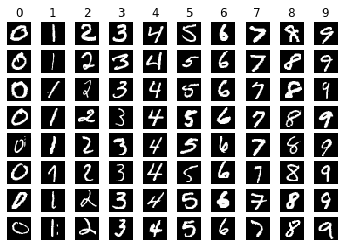

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = list(range(10))
for cls, cls_name in enumerate(classes):
    idxs = np.where((labels == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [16]:
train_v = train.reshape(N, -1)

In [17]:
U, S, Vh = np.linalg.svd(train_v, full_matrices=False)

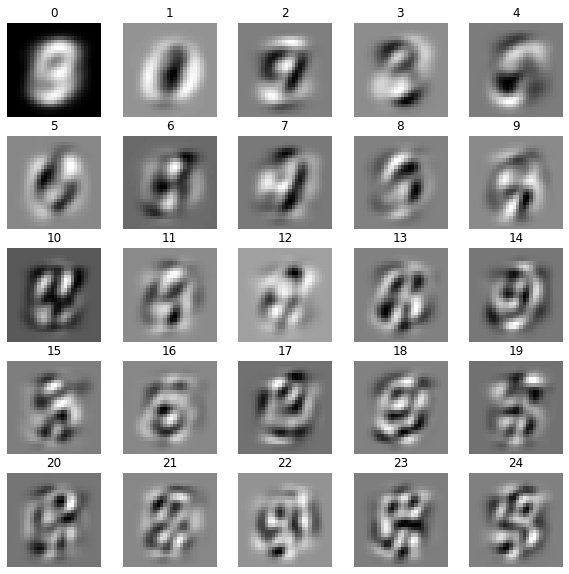

In [18]:
size = 5
plt.figure(figsize=(10,10))
for i, idx in enumerate(range(size**2)):#range(size**2):
  plt.subplot(size, size, i+1)
  plt.imshow(Vh[idx].reshape(28,28))
  plt.axis('off')
  plt.title(idx)

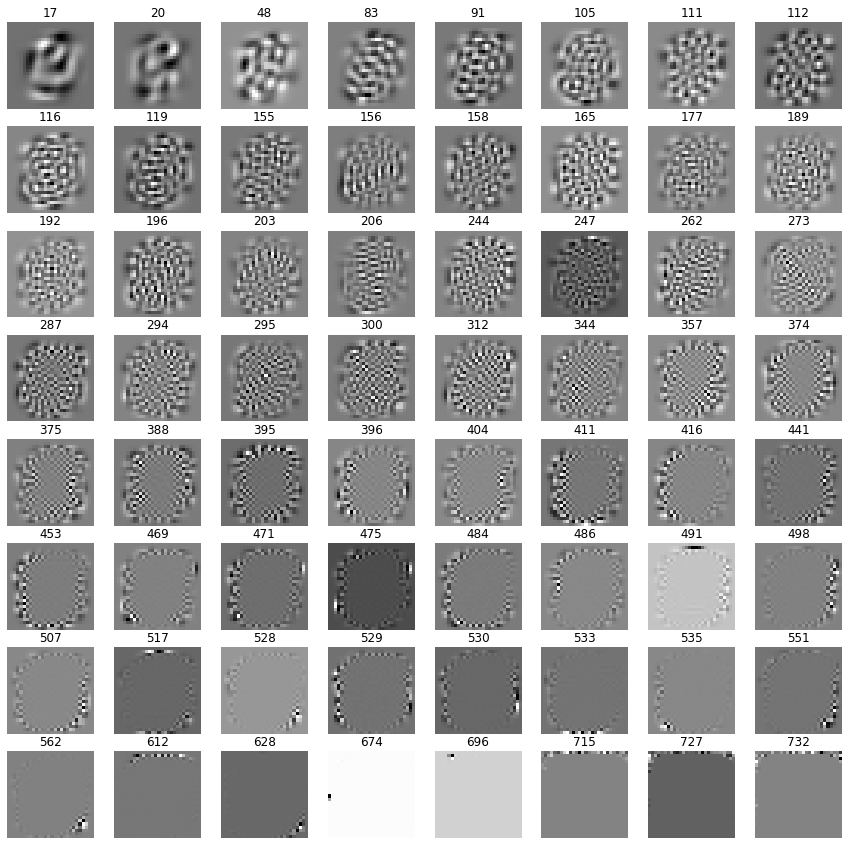

In [19]:
size = 8
plt.figure(figsize=(15,15))
for i, idx in enumerate(sorted(np.random.choice(list(range(Vh.shape[0])), size=size*size, replace=False))):#range(size**2):
  plt.subplot(size, size, i+1)
  plt.imshow(Vh[idx].reshape(28,28))
  plt.axis('off')
  plt.title(idx)

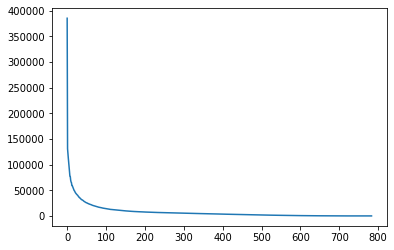

In [20]:
plt.plot(S)

## Where PCA breaks down